# Verificarlo demonstration - 2024-12-05
### P. Oliveira (Li-PaRAD, UVSQ, U. Paris-Saclay)
<img src="verificarlo-logo.png" width="100" />

[github.com/verificarlo/verificarlo](https://github.com/verificarlo/verificarlo) 

## Using verificarlo: a simple demonstration

In [1]:
!verificarlo -h

usage: verificarlo [-h] [-E] [-S] [-c] [-o file] [--ddebug]
                   [--function function] [--include-file file]
                   [--exclude-file file] [-static] [--verbose] [--inst-fcmp]
                   [--inst-fma] [--inst-cast] [--inst-func] [--show-cmd]
                   [--save-temps] [--version] [--linker {clang,flang,clang++}]
                   [--emit-llvm]

Compiles a program replacing floating point operation with calls to the mcalib
(Montecarlo Arithmetic).

options:
  -h, --help            show this help message and exit
  -E                    only run the preprocessor
  -S                    only run preprocess and compilation steps
  -c                    only run preprocess, compile, and assemble steps
  -o file               write output to <file>
  --ddebug              enable delta-debug mode
  --function function   only instrument <function>
  --include-file file   include-list module and functions
  --exclude-file file   exclude-list module and fun

In [2]:
%%writefile archimedes.c
#include <math.h>
#include <stdio.h>

/* Archimedes method for computing PI using circumscribed polygons */
double archimedes(int N) {
  double ti, tii, fact, res;

  /* Print header */
  fprintf(stderr, "i\tAi+1\tTi+1\n");

  ti = 1. / sqrt(3.);
  fact = 1;
  for (int i = 1; i <= N; i++) {
    double s = sqrt(ti * ti + 1);
    tii = (s - 1) / ti;
    ti = tii;
    fact *= 2;
    res = 6 * fact * tii;
    fprintf(stderr, "%2d\t%.16e\t%.16e\n", i, res, tii);
  }
  return res;
}

int main(void) {
  /* Approximate pi with 20 iterations of the Archimedes method */
  const int N = 20;
  double pi = archimedes(N);
  printf("%.15e\n", pi);
  return 0;
}


Overwriting archimedes.c


In [3]:
!rm *.ll
!verificarlo-c --save-temps --inst-fma --ddebug -g archimedes.c -o archimedes -lm

In [4]:
!diff -u --minimal --color archimedes*.1.ll archimedes*.2.ll

--- archimedes.ul8elbv5.1.ll	2024-12-04 08:12:57.375587869 +0100
+++ archimedes.vs1g7icr.2.ll	2024-12-04 08:12:57.417587340 +0100
@@ -1,4 +1,4 @@
-; ModuleID = 'archimedes.c'
+; ModuleID = '/home/poliveira/demo-verificarlo-hceres/archimedes.ul8elbv5.1.ll'
 source_filename = "archimedes.c"
 target datalayout = "e-m:e-p270:32:32-p271:32:32-p272:64:64-i64:64-f80:128-n8:16:32:64-S128"
 target triple = "x86_64-pc-linux-gnu"
@@ -30,8 +30,8 @@
   call void @llvm.dbg.declare(metadata double* %6, metadata !24, metadata !DIExpression()), !dbg !25
   %9 = load %struct._IO_FILE*, %struct._IO_FILE** @stderr, align 8, !dbg !26
   %10 = call i32 (%struct._IO_FILE*, i8*, ...) @fprintf(%struct._IO_FILE* noundef %9, i8* noundef getelementptr inbounds ([13 x i8], [13 x i8]* @.str, i64 0, i64 0)), !dbg !27
-  %11 = call double @sqrt(double noundef 3.000000e+00) #4, !dbg !28
-  %12 = fdiv double 1.000000e+00, %11, !dbg !29
+  %11 = call double @sqrt(double noundef 3.000000e+00) #6, !dbg !28
+  %12 = call d

In [5]:
!VFC_BACKENDS="libinterflop_ieee.so" ./archimedes

Info [verificarlo]: loaded backend libinterflop_ieee.so
Info [interflop-ieee]: load backend with:
Info [interflop-ieee]: debug = false
Info [interflop-ieee]: debug-binary = false
Info [interflop-ieee]: no-backend-name = false
Info [interflop-ieee]: print-new-line = false
Info [interflop-ieee]: print-subnormal-normalized = false
Info [interflop-ieee]: count-op = false
i	Ai+1	Ti+1
 1	3.2153903091734750e+00	2.6794919243112292e-01
 2	3.1596599420975098e+00	1.3165249758739625e-01
 3	3.1460862151314668e+00	6.5543462815238887e-02
 4	3.1427145996455734e+00	3.2736610412974723e-02
 5	3.1418730499798659e+00	1.6363922135311803e-02
 6	3.1416627470550682e+00	8.1814134037892401e-03
 7	3.1416101765995217e+00	4.0906382507806269e-03
 8	3.1415970343233370e+00	2.0453105692209224e-03
 9	3.1415937488168559e+00	1.0226542151096536e-03
10	3.1415929278736332e+00	5.1132697393776582e-04
11	3.1415927256225915e+00	2.5566347050965098e-04
12	3.1415926717415452e+00	1.2783173306240011e-04
13	3.1415926189008863e+00	6.39

In [6]:
!VFC_BACKENDS="libinterflop_mca_int.so --mode=mca" ./archimedes 2> /dev/null

3.140398006797074e+00


## Significant digits and confidence interval

In [7]:
%matplotlib inline
import math
from helpers import *

In [8]:
samples = []
for _ in range(30):
    out = !VFC_BACKENDS="libinterflop_mca_int.so --mode=rr" ./archimedes 2> /dev/null
    samples.append(float(out[0]))    

samples=np.array(samples)
Z=samples/math.pi-1.0
pprint(samples)

array([3.14185462, 3.14185496, 3.14053803, 3.14052156, 3.1419424 ,
       3.14053795, 3.14185496, 3.1419424 , 3.1405435 , 3.14194232,
       3.14054349, 3.14194206, 3.14054213, 3.14054341, 3.14053803,
       3.14045609, 3.14054213, 3.14052165, 3.14159267, 3.14193659,
       3.14045609, 3.14185496, 3.14054341, 3.14054341, 3.14185462,
       3.14045575, 3.14054315, 3.14185462, 3.14053803, 3.14054349])


In [9]:
print_errors(Z)

z                   s10  s2
0.00008338782711159   4  13
0.00008349526802309   4  13
0.00033569709156878   3  11
0.00034094037334220   3  11
0.00011132716336326   3  13
0.00033572298543161   3  11
0.00008349528950613   4  13
0.00011132886199827   3  13
0.00033395667902592   3  11
0.00011130125783954   3  13
0.00033395837864403   3  11
0.00011121844534090   3  13
0.00033439167709370   3  11
0.00033398427255726   3  11
0.00033569709148762   3  11
0.00036177786066327   3  11
0.00033439305668670   3  11
0.00034091150820381   3  11
0.00000000577779957   8  27
0.00010947895812241   3  13
0.00036177788222402   3  11
0.00008349526794094   4  13
0.00033398554602659   3  11
0.00033398427247344   3  11
0.00008338655302564   4  13
0.00036188654707159   3  11
0.00033406704652084   3  11
0.00008338655302409   4  13
0.00033569709156944   3  11
0.00033395837866457   3  11


11 bits are significant (with no failures in the sample data) with p = 0.900 and alpha = 0.95


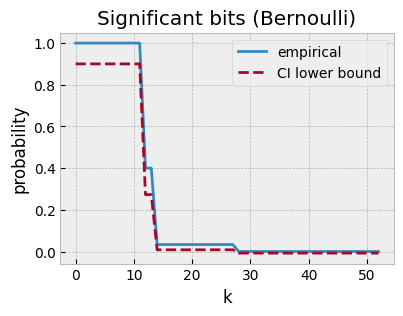

In [10]:
kth_significant  = np.array([count_success(Z, lambda z: significant(z, k)) for k in range(53)])
bernoulli_ci(kth_significant, Z.size, .95, "Significant")

## Pinpointing and fixing the error

Delta-Debug (DD) is a general bug reduction method that allows to efficiently find a
minimal set of conditions that trigger a bug.

<table>
<caption>Example of Delta-Debug bug minimization</caption>
<thead>
<tr class="header">
<th style="text-align: left;">Step</th>
<th style="text-align: center;">Instructions with noise</th>
<th style="text-align: right;">Numerically Stable</th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td style="text-align: left;">1</td>
<td style="text-align: center;">1 2 3 4 . . . .</td>
<td style="text-align: right;">stable</td>
</tr>
<tr class="even">
<td style="text-align: left;">2</td>
<td style="text-align: center;">. . . . 5 6 7 8</td>
<td style="text-align: right;">unstable</td>
</tr>
<tr class="odd">
<td style="text-align: left;">3</td>
<td style="text-align: center;">. . . . 5 6 . .</td>
<td style="text-align: right;">stable</td>
</tr>
<tr class="even">
<td style="text-align: left;">4</td>
<td style="text-align: center;">. . . . . . 7 8</td>
<td style="text-align: right;">unstable</td>
</tr>
<tr class="odd">
<td style="text-align: left;">5</td>
<td style="text-align: center;">. . . . . . 7 .</td>
<td style="text-align: right;">unstable</td>
</tr>
<tr class="even">
<td style="text-align: left;">Result (ddmin)</td>
<td style="text-align: center;">. . . . . . 7 .</td>
<td style="text-align: right;"></td>
</tr>
</tbody>
</table>



In [11]:
!verificarlo-c --ddebug -O0 -g archimedes.c -o archimedes -lm

In [12]:
!VFC_BACKENDS="libinterflop_cancellation.so --tolerance 1" vfc_ddebug ddRun ddCmp

/home/poliveira/demo-verificarlo-hceres/dd.line/294125a915071bd667d7ce20cd226350 --(cache) -> FAIL
/home/poliveira/demo-verificarlo-hceres/dd.line/294125a915071bd667d7ce20cd226350 --(cache) -> FAIL
/home/poliveira/demo-verificarlo-hceres/dd.line/63159a6ea73be9cf9578ca08b119c0df --(cache) -> FAIL
/home/poliveira/demo-verificarlo-hceres/dd.line/ffe410bd5743deed309ad95cfe696494 --(cache)-> PASS(3)
/home/poliveira/demo-verificarlo-hceres/dd.line/7e6f178d4fe4f65fe2dfb8308d36ccf5 --(cache) -> FAIL
/home/poliveira/demo-verificarlo-hceres/dd.line/c6f6b7dac69598faf76343edd91f09bd --(cache) -> FAIL
ddmin0 (0x402424: archimedes at archimedes.c:15):
/home/poliveira/demo-verificarlo-hceres/dd.line/c6f6b7dac69598faf76343edd91f09bd --(cache) -> FAIL
/home/poliveira/demo-verificarlo-hceres/dd.line/85fecdbd47deb445a38dee930b4b47f9 --(cache)-> PASS(3)
/home/poliveira/demo-verificarlo-hceres/dd.line/0d4255a225ae3786a407616d809e04b2 --(cache)-> PASS(3)
/home/poliveira/demo-verificarlo-hceres/dd.line/20b45

In [ ]:
!gvim -q <(./vfc_dderrors.py archimedes dd.line/rddmin-cmp/dd.line.exclude) && true

\begin{align*}
  T_{i+1} & = \frac{\color{red}{\sqrt{T_i^2+1} - 1}}{T_i} = \frac{\sqrt{T_i^2+1} - 1}{T_i} \times \frac{\sqrt{T_i^2+1} + 1}{\sqrt{T_i^2+1} + 1} \\
          & = \frac{T_i}{\sqrt{T_i^2+1} + 1}
\end{align*}

In [13]:
%%writefile archimedes.c
#include <math.h>
#include <stdio.h>

/* Archimedes method for computing PI using circumscribed polygons */
double archimedes(int N) {
  double ti, tii, fact, res;

  /* Print header */
  fprintf(stderr, "i\tAi+1\tTi+1\n");

  ti = 1. / sqrt(3.);
  fact = 1;
  for (int i = 1; i <= N; i++) {
    double s = sqrt(ti * ti + 1);
    tii = ti / (s + 1); /* Rewritten from tii = (s - 1) / ti; to remove cancellation */ 
    ti = tii;
    fact *= 2;
    res = 6 * fact * tii;
    fprintf(stderr, "%2d\t%.16e\t%.16e\n", i, res, tii);
  }
  return res;
}

int main(void) {
  /* Approximate pi with 20 iterations of the Archimedes method */
  const int N = 20;
  double pi = archimedes(N);
  printf("%.15e\n", pi);
  return 0;
}


Overwriting archimedes.c


In [14]:
!verificarlo-c --save-temps --inst-fma --ddebug -g archimedes.c -o archimedes -lm

array([3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265,
       3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265,
       3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265,
       3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265,
       3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265,
       3.14159265, 3.14159265, 3.14159265, 3.14159265])
z                   s10  s2
0.00000000000008371  13  43
0.00000000000008371  13  43
0.00000000000008349  13  43
0.00000000000008371  13  43
0.00000000000008260  13  43
0.00000000000008393  13  43
0.00000000000008260  13  43
0.00000000000008371  13  43
0.00000000000008371  13  43
0.00000000000008371  13  43
0.00000000000008238  13  43
0.00000000000008371  13  43
0.00000000000008349  13  43
0.00000000000008393  13  43
0.00000000000008393  13  43
0.00000000000008260  13  43
0.00000000000008349  13  43
0.00000000000008349  13  43
0.00000000000008393  13  43
0.00000000000008393  13  43
0.00000000000008304  

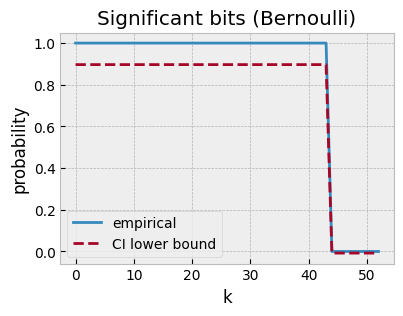

In [15]:
samples = []
for _ in range(29):
    out = !VFC_BACKENDS="libinterflop_mca_int.so --mode=rr" ./archimedes 2> /dev/null
    samples.append(float(out[0]))    

samples=np.array(samples)
Z=samples/math.pi-1.0
pprint(samples)
print_errors(Z)
kth_significant  = np.array([count_success(Z, lambda z: significant(z, k)) for k in range(53)])
bernoulli_ci(kth_significant, Z.size, .95, "Significant")